#  Convolutional Neural Network with Pre-Convolved Input

**This material is heavily based on the popular Standford CS231n lecture material.** [Please check on their website for more detailed information](https://cs231n.github.io/).

However, in this sectio, we are only going to implement the simplified version of a CNN. First, we will apply preconvolution to all training and testing datasets. Next, we will use the pre-convolved images to train a two-layer fully connected Neural Network.

In summary, the main difference is in how the network is trained (the backward pass). As for the forward pass, it is nevertheless similar to a CNN.

## Preparations
As usual, let's start with some preparations.

In [24]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 10,
})

from utils import *

np.set_printoptions(precision=5, suppress=True)


## Image Convolution

A convolution is done by multiplying a pixel’s and its neighboring pixels color value by a matrix (kernel matrix).

The convolution function is as follows, where:
* `img_in` is the image as a 2D matrix
* `kernel` is the filter kernel matrix
* `s` is the stride number

Typically, when `s=1`, the dimension should not change. This is possible if the image has been previously padded. For a `3x3` filter matrix, we need 1 layer of padding. For a `5x5` filter matrix, we will need two layes of padding. However, if the filter dimensions are even numbers, we will not be able to apply uniform padding. Check [this material](https://www.d2l.ai/chapter_convolutional-neural-networks/lenet.html) for more infomation.

In [25]:
def convolve_image(img_in, kernel, s):
    dim = kernel.shape
    nr, nc, = img_in.shape

    R = np.arange(0, nr - (dim[0] - s), s)
    C = np.arange(0, nc - (dim[1] - s), s)
    
    img_out = np.zeros([len(R), len(C)])

    for i, r in enumerate(R):
        for j, c in enumerate(C):
            img_out[i, j] =np.sum(kernel * img_in[r:r+dim[0], c:c+dim[1]])

    img_out = np.round(img_out / np.max(img_out) * 255.0)
    return np.int32(img_out)

## Max Pooling

Max pooling is a downsampling technique used in convolutional neural networks (CNNs) to reduce spatial dimensions of feature maps while preserving important features. It achieves this by selecting the maximum value within each small, overlapping region (or "window") of the feature map. 

In [26]:
def maxpool_image(img_in, dim, s):
    nr, nc, = img_in.shape

    R = np.arange(0, nr - (dim[0] - s), s)
    C = np.arange(0, nc - (dim[1] - s), s)
    
    img_out = np.zeros([len(R), len(C)])

    for i, r in enumerate(R):
        for j, c in enumerate(C):
            img_out[i, j] = np.max(img_in[r:r+dim[0], c:c+dim[1]])

    img_out = np.round(img_out / np.max(img_out) * 255.0)
    return np.int32(img_out)

Let's now do the convolution. The dimension of the filter matrix is 3x3 and the stride is 1.

## Diagram of the neural network

![](./images/2fcnn.png)

## class TwoLayerNet

Here, we are using the the ScyPy instead of our previous gradient descent method. There are: `D*H+H*C+H+C` variables that we must solve. For this reasons, our vanilla gradient descent method often gives unsatisfactory results.

In [27]:
class TwoLayerNet():
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """


    def __init__(self, input_size, hidden_size, output_size, std=1e-5):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)


    @staticmethod
    def loss(W1, b1, W2, b2, X, Y, reg=0.0, grad=False):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - Y: Vector of training labels. Y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= Y[i] < C. This parameter is optional; if it
        is not passed then we only return scores, and if it is passed then we
        instead return the loss and gradients.
        - reg: Regularization strength.
        - grad: flag to or NOT to return the loss gradients

        Returns:
        - loss: Loss (data loss and regularization loss) for this batch of training
        samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
        with respect to the loss function; has the same keys as self.params.
        """
        N, D = X.shape

        # Compute the forward pass
        fc1 = X.dot(W1) + b1     # fully connected
        X2 = np.maximum(0, fc1)  # ReLU
        F = X2.dot(W2) + b2 # fully connected
        
        # Compute the loss 
        F = F - np.max(F, axis=1).reshape(-1,1)
        expF = np.exp(F)
        softmax = expF/np.sum(expF, axis=1).reshape(-1,1) 
        loss = np.sum(-np.log(softmax[range(N),Y])) / N + reg  * (np.sum(W2 * W2) + np.sum( W1 * W1 ))
        
        if grad == True: # loss gradient is optionals
            # Backward pass: compute gradients
            softmax[np.arange(N) ,Y] -= 1
            softmax /= N

            # W2 gradient
            dW2 = X2.T.dot(softmax)   # [HxN] * [NxC] = [HxC]

            # b2 gradient
            db2 = softmax.sum(axis=0)

            # W1 gradient
            dW1 = softmax.dot(W2.T)   # [NxC] * [CxH] = [NxH]
            dfc1 = dW1 * (fc1>0)      # [NxH] . [NxH] = [NxH]
            dW1 = X.T.dot(dfc1)       # [DxN] * [NxH] = [DxH]

            # b1 gradient
            db1 = dfc1.sum(axis=0)

            # regularization gradient
            dW1 += reg * 2 * W1
            dW2 += reg * 2 * W2

            dW = np.hstack((dW1.flatten(), db1, dW2.flatten(), db2))
        
            return (loss, dW)
        
        return loss


    def train(self, X, Y, reg=1e-5, gtol=1e-5, maxiter=1000, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
        X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - verbose: boolean; if true print progress during optimization.
        """
        self.params["loss_history"] = []

        D, H = self.params['W1'].shape
        H, C = self.params['W2'].shape

        def obj(x):
            W1 = x[0: D*H].reshape(D,H)
            b1 = x[D*H: D*H+H]
            W2 = x[D*H+H: D*H+H+(H*C)].reshape(H,C)
            b2 = x[D*H+H+(H*C):]

            loss = self.loss(W1, b1, W2, b2, X, Y, reg=reg, grad=True)
            self.params["loss_history"].append(loss[0])

            if verbose == True:
                print(loss)

            return loss

        x0 = np.hstack((self.params['W1'].flatten(), 
                        self.params['b1'], 
                        self.params['W2'].flatten(), 
                        self.params['b2']))
        res = minimize(obj, x0, method='L-BFGS-B', jac=True, options={'gtol': gtol, 'maxiter': maxiter, 'disp': True})

        self.params["W1"] = res.x[0: D*H].reshape(D,H)
        self.params["b1"] = res.x[D*H: D*H+H]
        self.params["W2"] = res.x[D*H+H: D*H+H+(H*C)].reshape(H,C)
        self.params["b2"] = res.x[D*H+H+(H*C):]
    

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
        classify.

        Returns:
        - Y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """

        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        # Compute the forward pass
        fc1 = X.dot(W1) + b1     # fully connected
        X2 = np.maximum(0, fc1)  # ReLU
        scores = X2.dot(W2) + b2 # fully connected
    
        y_pred = np.argmax( scores, axis=1)
        
        return y_pred

----

## Handwritten Digits

This dataset is publicly available and can be downloaded from [this link](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits).

First, we will start with loading all datasets.

In [28]:
import h5py
with h5py.File("./datasets/usps/usps.h5", 'r') as hf:
    X_train = hf.get("train").get('data')[:] * 255.0
    Y_train = np.int32(hf.get("train").get('target')[:]) 

    X_test = hf.get("test").get('data')[:] * 255.0
    Y_test = np.int32(hf.get("test").get('target')[:]) 

print("Dimension numbers :", X_train.shape[1])
print("Number of data    :", X_train.shape[0])


Dimension numbers : 256
Number of data    : 7291


### Border Padding

Here, we are going to pad the image border with zeros to avoid information loss around at the border. We will add:
* 1 row above the first row
* 1 row below the last row
* 1 column in the left-side of the first column
* 1 column in the right-side of the last column

Since the original image is 16x16, the padded image will be 18x18.

In [29]:
X_train_paded = []
for x in X_train:
    x_ = np.zeros([18, 18])
    x_[1:-1, 1:-1] = x.reshape(16,16)
    X_train_paded.append(x_.reshape(1,-1))

X_test_padded = []
for x in X_test:
    x_ = np.zeros([18, 18])
    x_[1:-1, 1:-1] = x.reshape(16,16)
    X_test_padded.append(x_.reshape(1,-1))

### Apply Covolution and Max Pooling to Datasets

Next, we will apply convolution and max pooling to both datasets.

In [30]:
import os

f1 = "./X_train_conv.txt"
f2 = "./X_test_conv.txt"

if os.path.exists(f1):
    os.remove(f1)

if os.path.exists(f2):
    os.remove(f2)

# Gussian filter kernel
kernel = 1/16 * np.array([[1, 2, 1],
                          [2, 4, 2],
                          [1, 2, 1]])

with open(f1, "ab") as f:
    for x in X_train_paded:
        img_out = convolve_image(x.reshape(18,18), kernel, 1)
        img_out = maxpool_image(img_out, [2, 2], 2)
        np.savetxt(f, img_out.reshape(1,-1), fmt="%i", delimiter=',', newline='\n')

with open(f2, "ab") as f:
    for x in X_test_padded:
        img_out = convolve_image(x.reshape(18,18), kernel, 1)
        img_out = maxpool_image(img_out, [2, 2], 2)
        np.savetxt(f, img_out.reshape(1,-1), fmt="%i", delimiter=',', newline='\n')

Now, let's continue with training the network by using train dataset:

In [31]:
X_train_conv = np.loadtxt(f1, delimiter=",", dtype=int)

print("Dimension numbers :", X_train_conv.shape[1])
print("Number of data    :", X_train_conv.shape[0])
print("Labels            :", np.unique(Y_train))

# For the NN
input_size  = X_train_conv.shape[1]
num_classes = len(np.unique(Y_train))

Dimension numbers : 64
Number of data    : 7291
Labels            : [0 1 2 3 4 5 6 7 8 9]


In [32]:
X_test_conv = np.loadtxt(f2, delimiter=",", dtype=int)

print("Dimension numbers :", X_test_conv.shape[1])
print("Number of data    :", X_test_conv.shape[0])
print("Labels            :", np.unique(Y_test))

Dimension numbers : 64
Number of data    : 2007
Labels            : [0 1 2 3 4 5 6 7 8 9]


#### After Convolution and Max Pooling

Here, we are going to plot some of the convolved images.

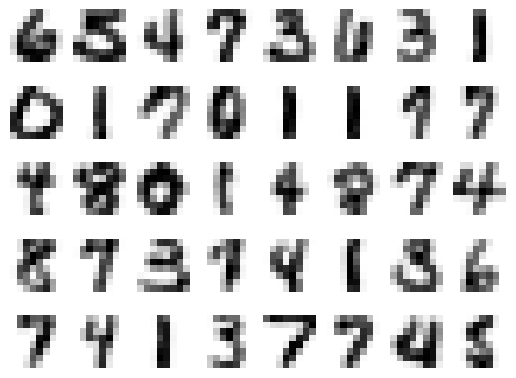

In [33]:
n = np.int32(np.sqrt(X_train_conv.shape[1]))

for i in range(40):
    X_train_conv_ = X_train_conv[i,:].reshape(n, n)
    plt.subplot(5, 8, i + 1)
    # Rescale the weights to be between 0 and 255
    plt.imshow(X_train_conv_.astype('uint8'), cmap='Greys')
    plt.axis('off')

#### The Original Images

For comparison, let's plot some of the original images.

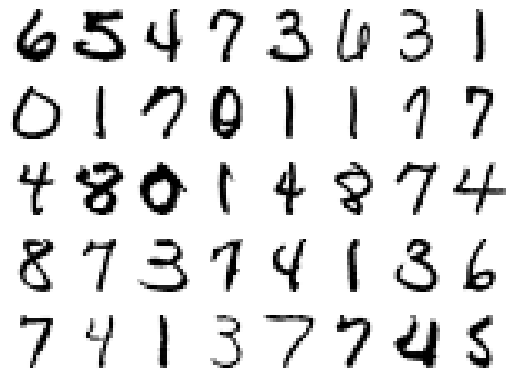

In [34]:
for i in range(40):
    X_train_ = X_train[i,:].reshape(16,16)
    plt.subplot(5, 8, i + 1)
    # Rescale the weights to be between 0 and 255
    plt.imshow(X_train_.astype('uint8'), cmap='Greys')
    plt.axis('off')

### Training and Testing the Neural Network

Now, let us setup and then train the neural network.

In [62]:
hidden_size = 50

net = TwoLayerNet(input_size, hidden_size, num_classes)
stats = net.train(X_train_conv, Y_train, reg=0.05, gtol=1e-3, maxiter=100, verbose=False)

Next, we check the accuray for training and test dataset.

In [63]:
# Predict on the validation set
train_acc = (net.predict(X_train_conv) == Y_train).mean()
print('Training accuracy : ', train_acc)

# Predict on the test set
test_acc = (net.predict(X_test_conv) == Y_test).mean()
print('Test accuracy     : ', test_acc)

Training accuracy :  0.9791523796461391
Test accuracy     :  0.9292476332835077


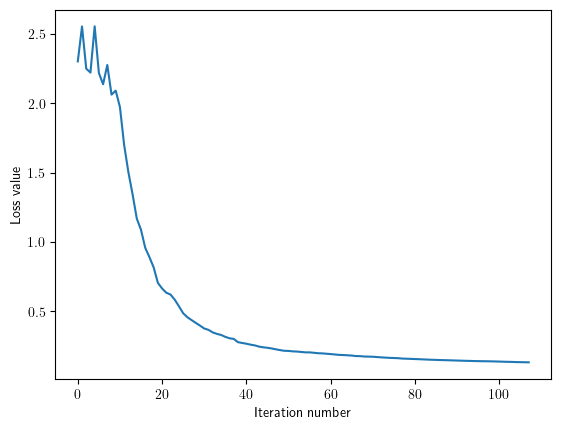

In [64]:
plt.plot(net.params["loss_history"])
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Save The Matrix for Arduino Demostration

In [ ]:
np.savetxt('W1_CNN.txt', 
           np.float16(np.hstack((net.params["W1"].transpose(), net.params['b1'].reshape(-1,1)))), 
           delimiter='\0\n', fmt='%.1e', newline='\0\n')

np.savetxt('W2_CNN.txt', 
           np.float16(np.hstack((net.params["W2"].transpose(), net.params['b2'].reshape(-1,1)))), 
           delimiter='\0\n', fmt='%.1e', newline='\0\n')